## Методические указания по выполнению лабораторной работы №5

**Тема: Обучение модели YOLO на кастомном датасете и исследование влияния гиперпараметров на качество детекции**

**Цель работы:** Познакомиться с архитектурой YOLO на примере проверки гипотезы о релевантной метрике.

**Задачи:**

- Ознакомиться с архитектурой YOLO.
- Изучить метрики для анализа производительности модели, выбрать целевую метрику в соответствии с вариантом.
- Выбрать предметную область, сформировать гипотезу для проведения исследования.
- Собрать и проаннотировать данные, сформировать датасет.
- Провести fine-tuning предобученной модели YOLOv11 Nano/Small.
- Визуализировать и проанализировать результаты.
- На основе анализа сделать корректировку гиперпараметров/данных и провести вторую итерацию для повышения показателей.

### 1. Подготовка к обучению

#### 1.1 Метрики

Вариант 1 - Precision

Вариант 2 - Recall

Вариант 3 - F1

Вариант 4 - mAP@0.5

Вариант 5 - mAP@0.75


#### 1.2 Гипотеза

Гипотеза должна отражать характер уклона исследования с обоснованием, отталкиваясь от предметной области. *Одна лишь констатация необходимости достижения высокого значения целевой метрики не является обоснованием*.

#### 1.3 Данные

Соберите не менее 500 изображений из открытых источников. Можно пользоваться готовыми наборами данных, но важно проверить качество: разрешение изображений, качество аннотаций, баланс классов. При самостоятельном сборе данных можете воспользоваться терминальной утилитой ffmpeg для нарезки видео на кадры и любым удобным инструментом аннотирования (Roboflow, CVAT и тд).

#### 1.4 Предобработка

Примените методы аугментации к данным для расширения объема датасета для получения 1.5-2к изображений. Подготовьте данные к требуемому формату для обучающего процесса.

### 2. Обучение модели

#### 2.1 Подготовка окружения

Установите зависимости и библиотеки:

In [5]:
!pip install ultralytics torch torchvision roboflow supervision --quiet
!pip install matplotlib opencv-python

import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import supervision as sv
import numpy as np
import os
from roboflow import Roboflow

#### 2.2 Подготовка модели

Загрузите предобученную модель, определите устройство, переведите модель в режим инференса. Не используйте размер модели больше чем Small для достижения лучших показателей на стандартных гиперпараметрах (особенно imgsz)

In [6]:
model = YOLO('yolo11n.pt')  # YOLOv11 Nano
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


#### 2.3 Загрузка и предобработка изображений


Затем импортируйте датасет в проект и выполните трансформацию данных (при использовании Roboflow трансформация выполняется на этапе предобработки):

In [7]:
rf = Roboflow(api_key="OSddHFo5XjN9g9RJI9qj")
project = rf.workspace("usmanchaudhry622-gmail-com").project("traffic-and-road-signs")
dataset = project.version(1).download("yolov11")

data_yaml = dataset.location + "/data.yaml"
print(f"Data YAML: {data_yaml}")

loading Roboflow workspace...
loading Roboflow project...
Data YAML: /content/Traffic-and-Road-Signs-1/data.yaml


#### 2.4 Обучение, оценка модели и визуализация результатов

Проведите обучение модели, проанализируйте кривые обучения, метрики и тестовые данные. Сделайте вывод и корректироваки для достижения лучших показателей

 Начинаем обучение...
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Traffic-and-Road-Signs-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, pe

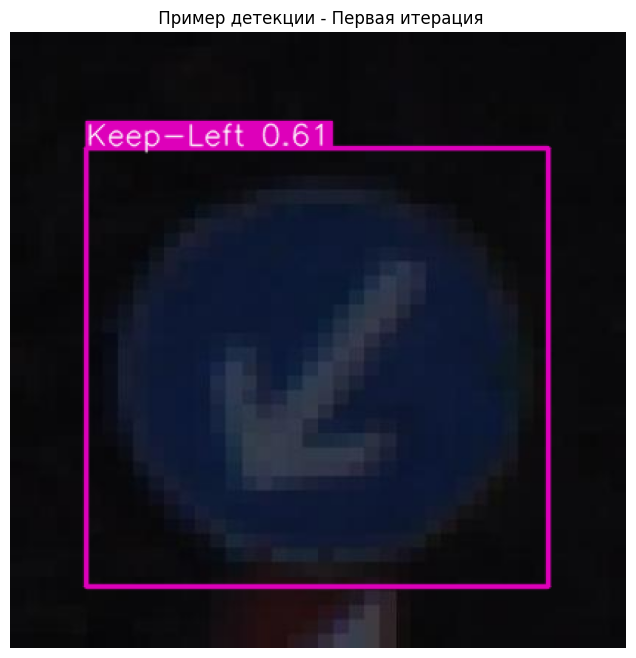

In [8]:
print(" Начинаем обучение...")


results = model.train(
    data=data_yaml,
    epochs=5,
    imgsz=640,
    batch=16,
    lr0=0.01,
    patience=10,
    device=device,
    plots=True,
    save=True,
    verbose=True,
    workers=2
)

print(" Обучение завершено")

# Оценка модели
print(" Оценка модели...")
metrics = model.val()
print("=== РЕЗУЛЬТАТЫ ПЕРВОЙ ИТЕРАЦИИ ===")
print(f"mAP@0.5:  {metrics.box.map50:.4f}")
print(f"mAP@0.75: {metrics.box.map75:.4f}")  # Наша целевая метрика
print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")

# Визуализация результатов
results_path = "runs/detect/train/"
if os.path.exists(results_path):
    # Графики обучения
    plot_path = os.path.join(results_path, "results.png")
    if os.path.exists(plot_path):
        img = cv2.imread(plot_path)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(' Кривые обучения - Первая итерация')
        plt.show()

    # Тестирование на валидационных данных
    val_images = [f for f in os.listdir(dataset.location + "/valid/images/") if f.endswith(('.jpg', '.png', '.jpeg'))]
    if val_images:
        test_image_path = os.path.join(dataset.location + "/valid/images/", val_images[0])
        print(f" Тестируем на изображении: {val_images[0]}")

        results = model.predict(test_image_path, save=True, conf=0.5)

        # Показываем результат
        result_image = results[0].plot()
        plt.figure(figsize=(10, 8))
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(' Пример детекции - Первая итерация')
        plt.show()

#### 2.5 Вторая итерация

Проведите процедуры для достижения высоких показателей (корректировка данных/гиперпараметров), сделайте вывод


 Начинаем вторую итерацию...
 Загружены лучшие веса из первой итерации
Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Traffic-and-Road-Signs-1/data.yaml, degrees=2.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs/detect/train/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset

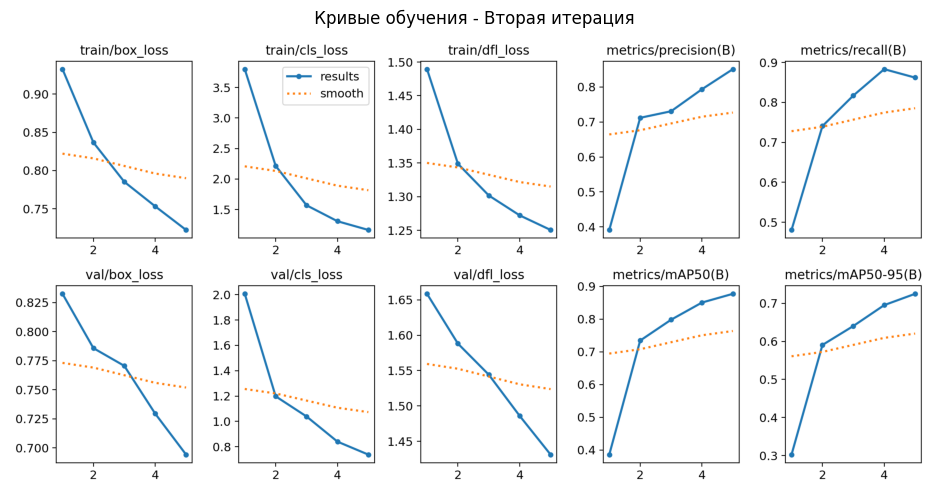

 Финальное тестирование на: 00027_00006_00013_png_jpg.rf.8ca234ed019c711449a2b64d063026e8.jpg

image 1/1 /content/Traffic-and-Road-Signs-1/valid/images/00027_00006_00013_png_jpg.rf.8ca234ed019c711449a2b64d063026e8.jpg: 640x640 1 Pedestrian Crossing, 14.8ms
Speed: 4.3ms preprocess, 14.8ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /content/runs/detect/train33


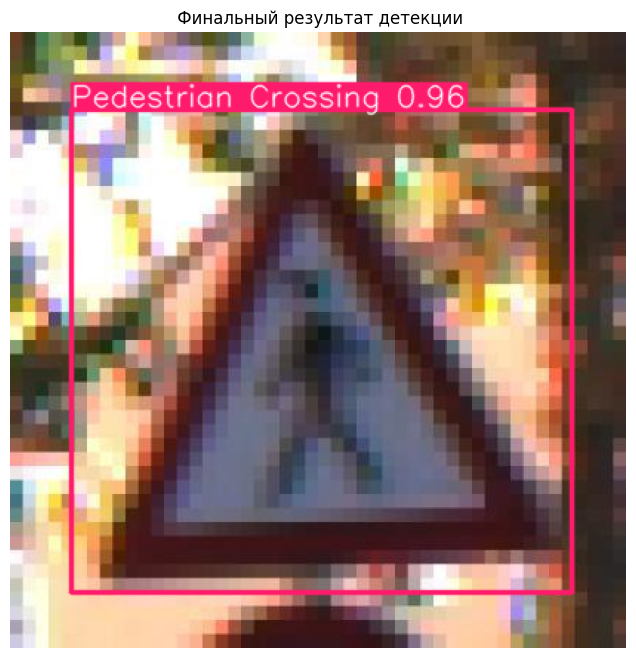


 Обучение завершено!


In [9]:
print(" Начинаем вторую итерацию...")

# Загружаем лучшие веса из первой итерации
model_path = "runs/detect/train/weights/best.pt"
if os.path.exists(model_path):
    model = YOLO(model_path)
    print(" Загружены лучшие веса из первой итерации")
else:
    print(" Файл с весами не найден, используем исходную модель")
    model = YOLO('yolo11n.pt')

# Вторая итерация с оптимизированными параметрами
results_v2 = model.train(
    data=data_yaml,
    epochs=5,
    imgsz=640,
    batch=16,
    lr0=0.001,
    patience=8,
    device=device,
    plots=True,
    save=True,
    overlap_mask=False,
    degrees=2.0,
    translate=0.05,
    scale=0.1,
    shear=1.0
)

print(" Вторая итерация завершена")

# Финальная оценка
metrics_v2 = model.val()
print("\n" + "="*50)
print(" ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ")
print("="*50)
print(f"mAP@0.5:  {metrics_v2.box.map50:.4f}")
print(f"mAP@0.75: {metrics_v2.box.map75:.4f}")  # Целевая метрика
print(f"mAP@0.5:0.95: {metrics_v2.box.map:.4f}")

print("\n" + "="*50)
print(" СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*50)
print(f"mAP@0.75 улучшился на: {metrics_v2.box.map75 - metrics.box.map75:+.4f}")
print(f"mAP@0.5 улучшился на:  {metrics_v2.box.map50 - metrics.box.map50:+.4f}")

# Визуализация финальных результатов
results_path_v2 = "runs/detect/train2/"
if os.path.exists(results_path_v2):
    plot_path_v2 = os.path.join(results_path_v2, "results.png")
    if os.path.exists(plot_path_v2):
        img_v2 = cv2.imread(plot_path_v2)
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(img_v2, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(' Кривые обучения - Вторая итерация')
        plt.show()

# Финальное тестирование
val_images = [f for f in os.listdir(dataset.location + "/valid/images/") if f.endswith(('.jpg', '.png', '.jpeg'))]
if val_images:
    test_image_path = os.path.join(dataset.location + "/valid/images/", val_images[1] if len(val_images) > 1 else val_images[0])
    print(f" Финальное тестирование на: {os.path.basename(test_image_path)}")

    results_final = model.predict(test_image_path, save=True, conf=0.5)
    result_image_final = results_final[0].plot()

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(result_image_final, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(' Финальный результат детекции')
    plt.show()

print("\n Обучение завершено!")